In [1]:
import numpy as np
import scipy.special as scp
from collections import deque
import random
import pandas as pd

In [2]:
class Task:
    
    def __init__(self, T0 = 1, q = 3 / 5, Ybar = 10, N = 20, alpha = 0.5, rho  = 0.8):
        self.T = 0
        if(np.random.uniform() < q):
            self.T = T0
        else:
            self.T = round(T0 - Ybar * np.log(np.random.uniform()))
        beta = (N * rho * (T0 + (1 - q) * Ybar)) / 2
        EX = beta * scp.gamma(1 + 1 / alpha)
        aux = round(beta * ((-np.log(np.random.uniform())) ** (1 / alpha)))
        self.X = max([1, min([100 * EX, aux])])
        self.start_time = 0
        self.end_time = 0
        
    def copy(self):
        to_return = Task()
        to_return.T = self.T
        to_return.X = self.X
        to_return.start_time = self.start_time
        to_return.end_time = self.end_time
        return(to_return)
        
class Server:
    
    def __init__(self):
        self.queue = deque()
        self.current_task = None
        
    def task_remaining_time(self):
        if(self.current_task is None):
            return(float("+Inf"))
        else:
            return(self.current_task.X)
        
    def add_task(self, task):
        if(self.current_task is None):
            self.current_task = task
        else:
            self.queue.append(task)
        
    def go_next_task(self):
        previous_task = self.current_task
        if(len(self.queue) == 0):
            self.current_task = None
        else:
            self.current_task = self.queue.pop()
        return(previous_task)
    
    def length(self):
        if(self.current_task is None):
            return(0)
        else:
            return(len(self.queue) + 1)
    
    def all_remaining_time(self):
        if(self.current_task is None):
            return(0)
        to_return = self.current_task.X
        to_return = to_return + sum([task.X for task in list(self.queue)])
        return(to_return)
    
    def mean_remaining_time(self):
        if(self.current_task is None):
            return(0)
        else:
            return(self.all_remaining_time() / self.length())
    
    def max_rem_time(self):
        if(self.current_task is None):
            return(0)
        maximus = self.current_task.X
        for task in list(self.queue):
            if(task.X > maximus):
                maximus = task.X
        return(maximus)

In [3]:
def JSQ_simulation(messages, T0 = 1, q = 3 / 5, Ybar = 10, N = 20, alpha = 0.5, rho = 0.8):
    servers = [Server() for _ in range(N)]
    if(isinstance(messages, int)):
        tasks = deque([Task(T0, 1, Ybar, N, alpha, rho) for _ in range(messages)])
    else:
        tasks = deque(messages)
    times = []
    msg_overheads = []
    next_task = tasks.pop()
    current_time = 0
    while(not next_task is None):
        # print("Next task : " + str(next_task.T) + " Service time : " + str(next_task.X))
        # for index in range(len(servers)):
        #   to_print = ""
        #   if(not servers[index].current_task is None):
        #       to_print = to_print + " " + str(servers[index].current_task.X)
        #   for element in list(servers[index].queue):
        #       to_print = to_print + " | " + str(element.X)
        #   print("Server - " + str(index) + to_print)
        first_server_stopped = min(servers, key = lambda x : x.task_remaining_time()).task_remaining_time()
        servers_stopped = [server for server in servers if server.task_remaining_time() == first_server_stopped]
        time = min([first_server_stopped, next_task.T])
        current_time = current_time + time
        changed_task = False
        for server in servers:
            if(server.task_remaining_time() != first_server_stopped and not server.current_task is None):
                server.current_task.X = server.current_task.X - time
            elif(server.task_remaining_time() == first_server_stopped and time != first_server_stopped and first_server_stopped != float("+Inf")):
                server.current_task.X = server.current_task.X - time
        if(first_server_stopped <= next_task.T):
            for server in servers_stopped:
                completed_task = server.go_next_task()
                times.append(current_time - completed_task.start_time)
        if(next_task.T <= first_server_stopped):
            chosen_server = min(servers, key = lambda x : x.length())
            chosen_server.add_task(next_task)
            next_task.start_time = current_time
            if(len(tasks) == 0):
                next_task = None
            else:
                next_task = tasks.pop()
            changed_task = True
            msg_overheads.append(2 * N)
        if(not changed_task):
            next_task.T = next_task.T - time
    for server in servers:
        other_current_time = current_time
        if(not server.current_task is None):
            times.append(current_time + server.current_task.X - server.current_task.start_time)
            other_current_time = current_time + server.current_task.X
        for task in list(server.queue):
            other_current_time = other_current_time + task.X
            times.append(other_current_time - task.start_time)
    return(times, msg_overheads)

In [4]:
def JBT_simulation(messages, d = 3, T = None, T0 = 1, q = 3 / 5, Ybar = 10, N = 20, alpha = 0.5, rho = 0.8):
    if(T is None):
        T = 1000 * T0
    threshold = 1
    servers = [Server() for _ in range(N)]
    if(isinstance(messages, int)):
        tasks = deque([Task(T0, 1, Ybar, N, alpha, rho) for _ in range(messages)])
    else:
        tasks = deque(messages)
    times = []
    msg_overheads = []
    current_msg_overhead = 0
    next_task = tasks.pop()
    current_time = 0
    while(not next_task is None):
        first_server_stopped = min(servers, key = lambda x : x.task_remaining_time()).task_remaining_time()
        servers_stopped = [server for server in servers if server.task_remaining_time() == first_server_stopped]
        time = min([first_server_stopped, next_task.T])
        if(current_time % T != 0 and (current_time + time) % T == 0):
            current_msg_overhead = current_msg_overhead + 2 * N
            random_servers = random.choices(servers, k = d)
            threshold = min([serv.length() for serv in random_servers])
        current_time = current_time + time
        changed_task = False
        for server in servers:
            if(server.task_remaining_time() != first_server_stopped and not server.current_task is None):
                server.current_task.X = server.current_task.X - time
            elif(server.task_remaining_time() == first_server_stopped and time != first_server_stopped and first_server_stopped != float("+Inf")):
                server.current_task.X = server.current_task.X - time
        if(first_server_stopped <= next_task.T):
            for server in servers_stopped:
                completed_task = server.go_next_task()
                times.append(current_time - completed_task.start_time)
                if(server.length() == threshold - 1):
                    current_msg_overhead = current_msg_overhead + 1
        if(next_task.T <= first_server_stopped):
            msg_overheads.append(current_msg_overhead)
            current_msg_overhead = 0
            below_threshold = [server for server in servers if server.length() < threshold]
            if(len(below_threshold) == 0):
                chosen_server = random.choice(servers)
            else:
                chosen_server = random.choice(below_threshold)
            chosen_server.add_task(next_task)
            if(chosen_server.length() == threshold):
                current_msg_overhead = 1
            next_task.start_time = current_time
            if(len(tasks) == 0):
                next_task = None
            else:
                next_task = tasks.pop()
            changed_task = True
        if(not changed_task):
            next_task.T = next_task.T - time
    for server in servers:
        other_current_time = current_time
        if(not server.current_task is None):
            times.append(current_time + server.current_task.X - server.current_task.start_time)
            other_current_time = current_time + server.current_task.X
        for task in list(server.queue):
            other_current_time = other_current_time + task.X
            times.append(other_current_time - task.start_time)
    return(times, msg_overheads)

In [5]:
def POD_simulation(messages, d = 3, T0 = 1, q = 3 / 5, Ybar = 10, N = 20, alpha = 0.5, rho = 0.8):
    servers = [Server() for _ in range(N)]
    if(isinstance(messages, int)):
        tasks = deque([Task(T0, 1, Ybar, N, alpha, rho) for _ in range(messages)])
    else:
        tasks = deque(messages)
    times = []
    msg_overheads = []
    next_task = tasks.pop()
    current_time = 0
    while(not next_task is None):
        first_server_stopped = min(servers, key = lambda x : x.task_remaining_time()).task_remaining_time()
        servers_stopped = [server for server in servers if server.task_remaining_time() == first_server_stopped]
        time = min([first_server_stopped, next_task.T])
        current_time = current_time + time
        changed_task = False
        for server in servers:
            if(server.task_remaining_time() != first_server_stopped and not server.current_task is None):
                server.current_task.X = server.current_task.X - time
            elif(server.task_remaining_time() == first_server_stopped and time != first_server_stopped and first_server_stopped != float("+Inf")):
                server.current_task.X = server.current_task.X - time
        if(first_server_stopped <= next_task.T):
            for server in servers_stopped:
                completed_task = server.go_next_task()
                times.append(current_time - completed_task.start_time)
        if(next_task.T <= first_server_stopped):
            msg_overheads.append(2 * d)
            random_servers = random.choices(servers, k = d)
            chosen_server = min(random_servers, key = lambda x : len(x.queue))
            chosen_server.add_task(next_task)
            next_task.start_time = current_time
            if(len(tasks) == 0):
                next_task = None
            else:
                next_task = tasks.pop()
            changed_task = True
        if(not changed_task):
            next_task.T = next_task.T - time
    for server in servers:
        other_current_time = current_time
        if(not server.current_task is None):
            times.append(current_time + server.current_task.X - server.current_task.start_time)
            other_current_time = current_time + server.current_task.X
        for task in list(server.queue):
            other_current_time = other_current_time + task.X
            times.append(other_current_time - task.start_time)
    return(times, msg_overheads)

In [6]:
def NINA_simulation(messages, m = None, threshold_quantile = 0.5, T0 = 1, q = 3 / 5, Ybar = 10, N = 20, alpha = 0.5, rho = 8):
    if(m is None):
        m = N // 2
    light_servers = [Server() for _ in range(m)]
    heavy_servers = [Server() for _ in range(N - m)]
    servers = [server for server in light_servers]
    servers.extend(heavy_servers)
    if(isinstance(messages, int)):
        tasks = deque([Task(T0, 1, Ybar, N, alpha, rho) for _ in range(messages)])
    else:
        tasks = deque(messages)
    times = []
    msg_overheads = []
    next_task = tasks.pop()
    observed_times = [next_task.X]
    current_time = 0
    while(not next_task is None):
        first_server_stopped = min(servers, key = lambda x : x.task_remaining_time()).task_remaining_time()
        servers_stopped = [server for server in servers if server.task_remaining_time() == first_server_stopped]
        time = min([first_server_stopped, next_task.T])
        current_time = current_time + time
        changed_task = False
        for server in servers:
            if(server.task_remaining_time() != first_server_stopped and not server.current_task is None):
                server.current_task.X = server.current_task.X - time
            elif(server.task_remaining_time() == first_server_stopped and time != first_server_stopped and first_server_stopped != float("+Inf")):
                server.current_task.X = server.current_task.X - time
        if(first_server_stopped <= next_task.T):
            for server in servers_stopped:
                completed_task = server.go_next_task()
                times.append(current_time - completed_task.start_time)
        if(next_task.T <= first_server_stopped):
            threshold = np.quantile(observed_times[-1000:], threshold_quantile)
            if(next_task.X > threshold):
                msg_overheads.append(2 * (N - m))
                chosen_server = min(heavy_servers, key = lambda x : x.length())
            else:
                msg_overheads.append(2 * m)
                chosen_server = min(light_servers, key = lambda x : x.length())
            chosen_server.add_task(next_task)
            next_task.start_time = current_time
            if(len(tasks) == 0):
                next_task = None
            else:
                next_task = tasks.pop()
                observed_times.append(next_task.X)
            changed_task = True
        if(not changed_task):
            next_task.T = next_task.T - time
    for server in servers:
        other_current_time = current_time
        if(not server.current_task is None):
            times.append(current_time + server.current_task.X - server.current_task.start_time)
            other_current_time = current_time + server.current_task.X
        for task in list(server.queue):
            other_current_time = other_current_time + task.X
            times.append(other_current_time - task.start_time)
    return(times)

In [7]:
def ALT_simulation(messages, minimize = lambda server : server.all_remaining_time(), T0 = 1, q = 3 / 5, Ybar = 10, N = 20, alpha = 0.5, rho = 0.8):
    servers = [Server() for _ in range(N)]
    if(isinstance(messages, int)):
        tasks = deque([Task(T0, 1, Ybar, N, alpha, rho) for _ in range(messages)])
    else:
        tasks = deque(messages)
    times = []
    msg_overheads = []
    next_task = tasks.pop()
    current_time = 0
    while(not next_task is None):
        #print("Next task : " + str(next_task.T) + " Service time : " + str(next_task.X))
        #for index in range(len(servers)):
        #   to_print = ""
        #   if(not servers[index].current_task is None):
        #       to_print = to_print + " " + str(servers[index].current_task.X)
        #   for element in list(servers[index].queue):
        #       to_print = to_print + " | " + str(element.X)
        #   print("Server - " + str(index) + to_print)
        first_server_stopped = min(servers, key = lambda x : x.task_remaining_time()).task_remaining_time()
        servers_stopped = [server for server in servers if server.task_remaining_time() == first_server_stopped]
        time = min([first_server_stopped, next_task.T])
        current_time = current_time + time
        changed_task = False
        for server in servers:
            if(server.task_remaining_time() != first_server_stopped and not server.current_task is None):
                server.current_task.X = server.current_task.X - time
            elif(server.task_remaining_time() == first_server_stopped and time != first_server_stopped and first_server_stopped != float("+Inf")):
                server.current_task.X = server.current_task.X - time
        if(first_server_stopped <= next_task.T):
            for server in servers_stopped:
                completed_task = server.go_next_task()
                times.append(current_time - completed_task.start_time)
        if(next_task.T <= first_server_stopped):
            msg_overheads.append(2 * N)
            min_length = min([serv.length() for serv in servers])
            to_pick = [serv for serv in servers if serv.length() == min_length]
            chosen_server = min(to_pick, key = lambda x : minimize(x))
            chosen_server.add_task(next_task)
            next_task.start_time = current_time
            if(len(tasks) == 0):
                next_task = None
            else:
                next_task = tasks.pop()
            changed_task = True
        if(not changed_task):
            next_task.T = next_task.T - time
    for server in servers:
        other_current_time = current_time
        if(not server.current_task is None):
            times.append(current_time + server.current_task.X - server.current_task.start_time)
            other_current_time = current_time + server.current_task.X
        for task in list(server.queue):
            other_current_time = other_current_time + task.X
            times.append(other_current_time - task.start_time)
    return(times, msg_overheads)

In [33]:
messages = [Task() for _ in range(100000)]

In [10]:
FAST = ALT_simulation([task.copy() for task in messages])

In [11]:
FASTER = ALT_simulation([task.copy() for task in messages], minimize = lambda x : x.max_rem_time())

In [14]:
JSQ = JSQ_simulation([task.copy() for task in messages])

In [15]:
print("Mean time : " + str(np.mean(FAST[0])))
print("Mean msg overhead : " + str(np.mean(FASTER[1])))

Mean time : 110.05619
Mean msg overhead : 40.0


In [16]:
print("Mean time : " + str(np.mean(FASTER[0])))
print("Mean msg overhead : " + str(np.mean(FASTER[1])))

Mean time : 110.61092
Mean msg overhead : 40.0


In [17]:
print("Mean time : " + str(np.mean(JSQ[0])))
print("Mean msg overhead : " + str(np.mean(JSQ[1])))

Mean time : 124.09919
Mean msg overhead : 40.0


In [18]:
POD = POD_simulation([task.copy() for task in messages])

In [19]:
print("Mean time : " + str(np.mean(POD[0])))
print("Mean msg overhead : " + str(np.mean(POD[1])))

Mean time : 242.27189
Mean msg overhead : 6.0


In [34]:
JBT = JBT_simulation([task.copy() for task in messages])

In [35]:
print("Mean time : " + str(np.mean(JBT[0])))
print("Mean msg overhead : " + str(np.mean(JBT[1])))

Mean time : 463.9871
Mean msg overhead : 0.72866


In [22]:
len(JBT[1])

100000

In [8]:
#NINA
rho = []
times1 = []
msg1 = []
sd1 = []
sd2 = []
for ro in list(np.linspace(0.8,0.99,70)):
    temp1 = []
    temp2 = []
    for i in range(15):
        a = JSQ_simulation(100000, T0 = 1, q = 3 / 5, Ybar = 10, N = 20, alpha = 0.5, rho = ro)
        temp1.append(np.mean(a[0]))
        temp2.append(np.mean(a[1]))
    times1.append(np.mean(temp1))
    msg1.append(np.mean(temp2))
    sd1.append(np.std(temp1)/np.sqrt(15))
    sd2.append(np.std(temp2)/np.sqrt(15))
    rho.append(ro)    
d1 = {'rho':rho, 'meanDelay':times1, 'sd_time':sd1, 'MessageOverhead':msg1, 'sd_msg':sd2}
d1 = pd.DataFrame.from_dict(d1)
d1.to_csv('d1.csv', index = False)

KeyboardInterrupt: 

In [ ]:
#DAVIDE
rho = []
times1 = []
msg1 = []
sd1 = []
sd2 = []
for ro in list(np.linspace(0.8,0.99,70)):
    temp1 = []
    temp2 = []
    for i in range(15):
        a = JBT_simulation(100000, T0 = 1, q = 3 / 5, Ybar = 10, N = 20, alpha = 0.5, rho = ro)
        temp1.append(np.mean(a[0]))
        temp2.append(np.mean(a[1]))
    times1.append(np.mean(temp1))
    msg1.append(np.mean(temp2))
    sd1.append(np.std(temp1)/np.sqrt(15))
    sd2.append(np.std(temp2)/np.sqrt(15))
    rho.append(ro)    
d2 = {'rho':rho, 'meanDelay':times1, 'sd_time':sd1, 'MessageOverhead':msg1, 'sd_msg':sd2}
d2 = pd.DataFrame.from_dict(d2)
d2.to_csv('d2.csv', index = False)

In [9]:
#LEO
rho = []
times1 = []
msg1 = []
sd1 = []
sd2 = []
for ro in list(np.linspace(0.8,0.99,70)):
    temp1 = []
    temp2 = []
    for i in range(15):
        a = POD_simulation(100000, T0 = 1, q = 3 / 5, Ybar = 10, N = 20, alpha = 0.5, rho = ro)
        temp1.append(np.mean(a[0]))
        temp2.append(np.mean(a[1]))
    times1.append(np.mean(temp1))
    msg1.append(np.mean(temp2))
    sd1.append(np.std(temp1)/np.sqrt(15))
    sd2.append(np.std(temp2)/np.sqrt(15))
    rho.append(ro)    
d3 = {'rho':rho, 'meanDelay':times1, 'sd_time':sd1, 'MessageOverhead':msg1, 'sd_msg':sd2}
d3 = pd.DataFrame.from_dict(d3)
d3.to_csv('d3.csv', index = False)

NameError: name 'd1' is not defined

In [ ]:
#STEFANO
rho = []
times1 = []
msg1 = []
sd1 = []
sd2 = []
for ro in list(np.linspace(0.8,0.99,70)):
    temp1 = []
    temp2 = []
    for i in range(15):
        a = ALT_simulation(100000, T0 = 1, q = 3 / 5, Ybar = 10, N = 20, alpha = 0.5, rho = ro)
        temp1.append(np.mean(a[0]))
        temp2.append(np.mean(a[1]))
    times1.append(np.mean(temp1))
    msg1.append(np.mean(temp2))
    sd1.append(np.std(temp1)/np.sqrt(15))
    sd2.append(np.std(temp2)/np.sqrt(15))
    rho.append(ro)    
d4 = {'rho':rho, 'meanDelay':times1, 'sd_time':sd1, 'MessageOverhead':msg1, 'sd_msg':sd2}
d4 = pd.DataFrame.from_dict(d4)
d4.to_csv('d4.csv', index = False)

In [ ]:
#NINA2
rho = []
times1 = []
msg1 = []
sd1 = []
sd2 = []
for ro in list(np.linspace(0.8,0.99,70)):
    temp1 = []
    temp2 = []
    for i in range(15):
        a = NINA_simulation(100000, T0 = 1, q = 3 / 5, Ybar = 10, N = 20, alpha = 0.5, rho = ro)
        temp1.append(np.mean(a[0]))
        temp2.append(np.mean(a[1]))
    times1.append(np.mean(temp1))
    msg1.append(np.mean(temp2))
    sd1.append(np.std(temp1)/np.sqrt(15))
    sd2.append(np.std(temp2)/np.sqrt(15))
    rho.append(ro)    
d5 = {'rho':rho, 'meanDelay':times1, 'sd_time':sd1, 'MessageOverhead':msg1, 'sd_msg':sd2}
d5 = pd.DataFrame.from_dict(d5)
d5.to_csv('d5.csv', index = False)

In [3]:
#open dfs
d1 = pd.read_csv('d1.csv', low_memory = False)
d2 = pd.read_csv('d2.csv', low_memory = False)
d3 = pd.read_csv('d3.csv', low_memory = False)
d4 = pd.read_csv('d4.csv', low_memory = False)
#d5 = pd.read_csv('d5.csv', low_memory = False)

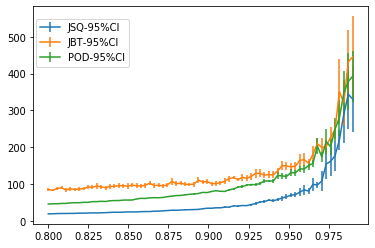

In [8]:
'''Plotting MEAN SYSTEM TIME'''

import matplotlib.pyplot as plt
fig = plt.figure()
#plt.plot(d1['rho'], d1['meanDelay'])#, label = "line 1")
plt.errorbar(d1['rho'],d1['meanDelay'] , yerr=1.96*d1['sd_time'], label='JSQ-95%CI')
#plt.plot(d2['rho'], d2['meanDelay'])#, label = "line 2")
plt.errorbar(d2['rho'],d2['meanDelay'] , yerr=1.96*d2['sd_time'], label='JBT-95%CI')
#plt.plot(d3['rho'], d3['meanDelay'])#, label = "line 3")
plt.errorbar(d3['rho'],d3['meanDelay'] , yerr=1.96*d3['sd_time'], label='POD-95%CI')
plt.legend(loc='lower right', bbox_to_anchor=(0., 0.7, 0.3, 0.2))


plt.savefig('MeanSystemTimeST.png')

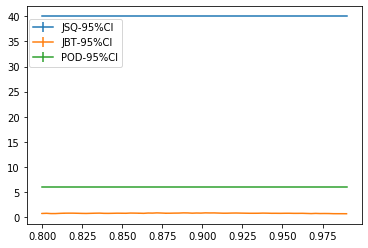

In [9]:
'''Plotting MEAN MESSAGE OVERHEAD'''

import matplotlib.pyplot as plt
fig = plt.figure()
plt.errorbar(d1['rho'],d1['MessageOverhead'] , yerr=1.96*d1['sd_msg'], label='JSQ-95%CI')
plt.errorbar(d2['rho'],d2['MessageOverhead'] , yerr=1.96*d2['sd_msg'], label='JBT-95%CI')
plt.errorbar(d3['rho'],d3['MessageOverhead'] , yerr=1.96*d3['sd_msg'], label='POD-95%CI')
plt.legend(loc='lower right', bbox_to_anchor=(0., 0.7, 0.3, 0.2))


plt.savefig('MeanMessageOverST.png')

# OUR METHOD VS JSQ

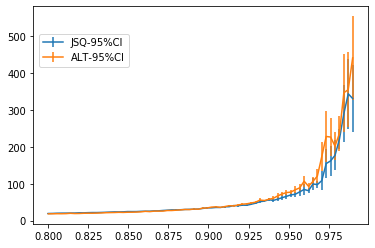

In [6]:
'''Plotting MEAN SYSTEM TIME'''

import matplotlib.pyplot as plt
fig = plt.figure()
plt.errorbar(d1['rho'],d1['meanDelay'] , yerr=1.96*d1['sd_time'], label='JSQ-95%CI')
plt.errorbar(d4['rho'],d4['meanDelay'] , yerr=1.96*d4['sd_time'], label='ALT-95%CI')

plt.legend(loc='lower right', bbox_to_anchor=(0., 0.7, 0.3, 0.2))


plt.savefig('MeanSystemTimeOUR.png')

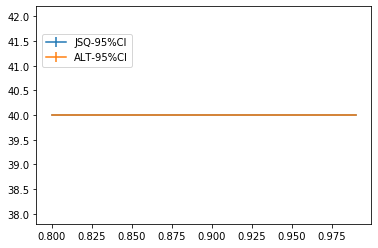

In [7]:
'''Plotting MEAN MESSAGE OVERHEAD'''

import matplotlib.pyplot as plt
fig = plt.figure()
plt.errorbar(d1['rho'],d1['MessageOverhead'] , yerr=1.96*d1['sd_msg'], label='JSQ-95%CI')
plt.errorbar(d4['rho'],d4['MessageOverhead'] , yerr=1.96*d4['sd_msg'], label='ALT-95%CI') #our method
plt.legend(loc='lower right', bbox_to_anchor=(0., 0.7, 0.3, 0.2))


plt.savefig('MeanMessageOverOUR.png')